In [3]:
import random, numpy as np, pandas as pd
from matplotlib import pyplot as plt
alphap = 2
probp = 0.75
expon = 2 * alphap - 1

In [4]:
def betadist(alpha):
    """gives a random number from beta distribution"""
    return random.betavariate(alpha,alpha)

In [5]:
def decision(probability):
    """
    decides with a given probability whether to keep the right part
    """
    if float(probability) > random.random():
        return True
    else: 
        return False

In [6]:
def splitting(left,right):
    """
    splits a given segment. left and right are endpoints of the segment
    """
    segment = right - left
    xL = segment * betadist(alphap)
    xR = segment - xL
    splitpoint = left + xL
    flag = decision(probp)
    xLp = xL**expon
    xRp = xR**expon
    change = xLp + xRp - segment**expon
    return splitpoint, flag, xLp, xRp, change

def splitting_v2(segment):
    """
    splits a given segment. left and right are endpoints of the segment
    returns : 
        xL -> length of the left segment
        xR -> length of the right segment
        flag -> keeping the right segment
        xLp, xRp -> probability(unnormalized) for being selected
        change -> change of normalization const
    """
    xL = segment * betadist(alphap)
    xR = segment - xL
    flag = decision(probp)
    xLp = xL**expon
    xRp = xR**expon
    change = xLp + xRp - segment**expon
    return xL, xR, flag, xLp, xRp, change

In [7]:
def pickindex(expons, exponsum):
    """
    picks up a segment to be subsequently split
    """
    r = random.uniform(0, exponsum)
    sum_ = 0
    for index in range(len(expons)):
        sum_ += expons[index]
        if sum_ < r:
            continue
        else:
            return index

In [8]:
def number_length(points,flags):
    
    N = 0
    M = 0
    
    for i in range(len(flags)):
        if flags[i]:
            N += 1
            M += points[i+1] - points[i] 
            pass
        pass
    return N, M

def number_length_v2(lengths,flags):
    
    N = 0
    M = 0
#     print(flags)
#     print(lengths)
    for i in range(len(flags)):
        if flags[i]:
            N += 1
            M += lengths[i]
            pass
        pass
    return N, M

In [9]:
def realization_value(total_iteration, min_iteration, iteration_step):
    
    points = [0.,1.]
    flags = [True]
    expons = [1.]
    exponsum = 1.0

    iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
    N_realization = []
    M_realization = []
    
    for i in range(total_iteration + 1):
        
        index = pickindex(expons, exponsum)
        
        if flags[index] == True:
            left = points[index]
            right = points[index+1]
            splitpoint, flag, xLp, xRp, change = splitting(left,right)
            points.insert(index+1,splitpoint)
            flags.insert(index+1,flag)
            expons[index] = xLp 
            expons.insert(index+1,xRp)
            exponsum += change
            pass
        
        if i+1 in iteration_list:
            N, M = number_length(points,flags)
            N_realization.append(N)
            M_realization.append(M)
        pass
    
    N_list = np.array(N_realization)
    M_list = np.array(M_realization)
    
    return N_list, M_list

In [10]:
def realization_value_v2(total_iteration, min_iteration, iteration_step):
    
    #points = [0.,1.]
    lengths = [1.]
    flags = [True]
    probabilities = [1.] # raw probability. not normalized
    normC = 1.0 # normalization const

    iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
    N_realization = []
    M_realization = []
    
    for i in range(total_iteration + 1):
        
        index = pickindex(probabilities, normC)
        
        if flags[index] == True:

            xL, xR, flag, xLp, xRp, change = splitting_v2(lengths[index])
            
            lengths[index] = xL
            lengths.append(xR)
            flags.append(flag)
            probabilities[index] = xLp 
            probabilities.append(xRp)
            normC += change
            pass
        
        if i+1 in iteration_list:
            N, M = number_length_v2(lengths,flags)
            N_realization.append(N)
            M_realization.append(M)
        pass
    
    N_list = np.array(N_realization)
    M_list = np.array(M_realization)
    
    return N_list, M_list

In [11]:
# realization_value_v2(10, 2, 2)
%timeit realization_value_v2(100000, 50000, 5000)

157 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit realization_value(100000, 50000, 5000)

The slowest run took 5.18 times longer than the fastest. This could mean that an intermediate result is being cached.
671 ms ± 348 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
def ensemble_average(total_iteration = 1000, min_iteration = 100, iteration_step = 100, ensemble_size = 1000):

    data_points = int ((total_iteration - min_iteration)/iteration_step + 1)
    N_ensemble = np.zeros(data_points)
    M_ensemble = np.zeros(data_points)
    
    for i in range(ensemble_size):
        if i % 100 == 0:
            print("iteration ", i)
        #N_list, M_list = realization_value(total_iteration, min_iteration, iteration_step)
        N_list, M_list = realization_value_v2(total_iteration, min_iteration, iteration_step)
        N_ensemble += N_list
        M_ensemble += M_list
        pass
    
    N_average = N_ensemble/ensemble_size
    M_average = M_ensemble/ensemble_size
    
    return N_average, M_average

iteration  0
iteration  100
iteration  200
iteration  300
iteration  400
iteration  500
iteration  600
iteration  700
iteration  800
iteration  900
0.7788405112543598


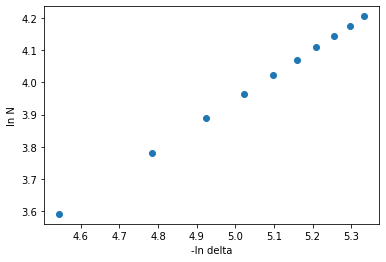

In [14]:
N_average, M_average = ensemble_average(10_000, 1_000, 1_000, 1_000)
N_log = np.log(N_average)
minus_delta_log = N_log - np.log(M_average)
slope, intercept = np.polyfit(minus_delta_log, N_log, 1)
print(slope)
plt.plot(minus_delta_log, N_log, "o")
plt.xlabel("-ln delta")
plt.ylabel("ln N")
plt.show()

## Testing

In [15]:
def f():
    arr = [   ]
    for a in range(1000):
        arr.insert(0, a)
    return arr

In [16]:
%timeit f()

323 µs ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
def g():
    arr = [0]*1000
    i = 1000-1
    for a in range(1000):
        arr[i] = a
        i -= 1
    return arr

In [18]:
%timeit g()

86.2 µs ± 7.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
685/129

5.310077519379845

In [20]:
np.array(f())

array([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987,
       986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974,
       973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961,
       960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948,
       947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935,
       934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922,
       921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909,
       908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896,
       895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883,
       882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870,
       869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857,
       856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844,
       843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831,
       830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 81

In [21]:
np.array(g())

array([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987,
       986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974,
       973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961,
       960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948,
       947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935,
       934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922,
       921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909,
       908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896,
       895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883,
       882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870,
       869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857,
       856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844,
       843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831,
       830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 81

## Idea to make it faster

1. each insert takes 5 times more time than just assigining value. because "insert" method inserts in some ranodm position 
2. same is not true for append. appends always inserts at the end
3. so we only need to replace insert method with something else
4. if we can find something where ordering or sequencing does not matter, this will be resolved
5. instead of points we can work with segment length only. and corresponding flag and probability. Like the table bellow

| length  | flag  | probability  |
|---|---|---|
|   |   |   |
|   |   |   |  
|   |   |   | 

7. Probably this can be made even faster by not using append in each iteration

# Performance
| method  | time
|---|---|
realization_value    | $1.19$ s
realization_value_v2 | $241$ ms

realization_value_v2 is $~5$ times faster

# Results
1. slope with realization_value    $0.779388458353189$
2. slope with realization_value_v2 $0.7841054354669876$
